In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'number-plate-detection:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2224491%2F3753395%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240611%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240611T045450Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D8319238e5313299caadb2c85f33926b78456e952439aae8eba83574eb89f04a4f54e66bf29f4e357306513c956a0622456a347d6c593395c6db4867bc8b2319c9f7cb7b4da680fe7e756d67819df6ea7b2291fc073ec2f1ae122bb49c7c68f77f416abe62eed47e5f205b4c7b1b0a47926a35ac478031f9799823cb4c07270350d4522493c34a2ccf112e599a818364362b96b14e646a750523ec9ce4d64762bd4281365be2157c7d7ed2adba7642e4264c274649946a064c6f145f4295b081c605217d57b826c3a5cc09a06a30697841ed899c5e49768dd6dfde4ed450e237ac2ae604f6c5aa24e80f0d216f2295fb66b7ca7aea1fa40f19f3bf3d301bce5dd'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 432553012 bytes downloaded
Downloaded and uncompressed: number-plate-detection
Data source import complete.


In [3]:
!pip install pytesseract


In [4]:
import numpy as np
import pandas as pd
import os
import cv2
import shutil
import tensorflow as tf
import pytesseract as pt
import plotly.express as px
import matplotlib.pyplot as plt
import xml.etree.ElementTree as xet
from glob import glob
from skimage import io
from shutil import copy
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import pandas as pd
import os
import cv2
import shutil
import tensorflow as tf
import pytesseract as pt
import plotly.express as px
import matplotlib.pyplot as plt
import xml.etree.ElementTree as xet
from glob import glob
from skimage import io
from shutil import copy
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [5]:
path ='/kaggle/input/number-plate-detection/images'

In [6]:
import os

# Define the path to your images directory
path = '/kaggle/input/number-plate-detection/images/'

# Initialize an empty dictionary to store bounding box information
labels_dict = dict(filepath=[], xmin=[], xmax=[], ymin=[], ymax=[])

# Iterate over the files in the directory
for file in sorted(os.listdir(path)):
    # Check if the file is an image file (you might need to adjust this condition based on your file naming convention)
    if file.endswith('.jpg') or file.endswith('.jpeg') or file.endswith('.png'):
        # Extract file name without extension
        file_name = os.path.splitext(file)[0]

        # Assuming the file name contains bounding box coordinates (e.g., "filename_xmin_ymin_xmax_ymax.jpg")
        parts = file_name.split('_')
        if len(parts) == 5:  # Assuming the file name has exactly 5 parts
            xmin, ymin, xmax, ymax = map(int, parts[1:])  # Extract bounding box coordinates
            # Append information to the dictionary
            labels_dict['filepath'].append(os.path.join(path, file))
            labels_dict['xmin'].append(xmin)
            labels_dict['xmax'].append(xmax)
            labels_dict['ymin'].append(ymin)
            labels_dict['ymax'].append(ymax)

# Print the extracted bounding box information
print(labels_dict)


{'filepath': [], 'xmin': [], 'xmax': [], 'ymin': [], 'ymax': []}


In [7]:
Lpd = pd.DataFrame(data=labels_dict)

In [8]:
Lpd.to_csv('labels.csv',index=False)
Lpd.head()

,filepath,xmin,xmax,ymin,ymax


In [9]:
labels_dict = dict(labelpath=[],imagepath=[],xmin=[],xmax=[],ymin=[],ymax=[])

for file in sorted(os.listdir(path)):
    if 'xml' in file:
        info = xet.parse(path+file)
        root = info.getroot()
        obj = root.find('object')
        l_info = obj.find('bndbox')
        xmin = int(l_info.find('xmin').text)
        xmax = int(l_info.find('xmax').text)
        ymin = int(l_info.find('ymin').text)
        ymax = int(l_info.find('ymax').text)

        labels_dict['labelpath'].append(path+file)
        labels_dict['xmin'].append(xmin)
        labels_dict['xmax'].append(xmax)
        labels_dict['ymin'].append(ymin)
        labels_dict['ymax'].append(ymax)
        labels_dict['imagepath'].append(path+file[:-3]+'jpeg')



In [10]:
labels_dict = dict(labelpath=[],imagepath=[],xmin=[],xmax=[],ymin=[],ymax=[])

for file in sorted(os.listdir(path)):
    if 'xml' in file:
        info = xet.parse(path+file)
        root = info.getroot()
        obj = root.find('object')
        l_info = obj.find('bndbox')
        xmin = int(l_info.find('xmin').text)
        xmax = int(l_info.find('xmax').text)
        ymin = int(l_info.find('ymin').text)
        ymax = int(l_info.find('ymax').text)

        labels_dict['labelpath'].append(path+file)
        labels_dict['xmin'].append(xmin)
        labels_dict['xmax'].append(xmax)
        labels_dict['ymin'].append(ymin)
        labels_dict['ymax'].append(ymax)
        labels_dict['imagepath'].append(path+file[:-3]+'jpeg')



In [11]:
len(labels_dict['imagepath'])

225

In [12]:
df = pd.DataFrame(labels_dict)


In [13]:
df.head()

,labelpath,imagepath,xmin,xmax,ymin,ymax
0,/kaggle/input/number-plate-detection/images/N1...,/kaggle/input/number-plate-detection/images/N1...,1093,1396,645,727
1,/kaggle/input/number-plate-detection/images/N1...,/kaggle/input/number-plate-detection/images/N1...,134,301,312,350
2,/kaggle/input/number-plate-detection/images/N1...,/kaggle/input/number-plate-detection/images/N1...,31,139,128,161
3,/kaggle/input/number-plate-detection/images/N1...,/kaggle/input/number-plate-detection/images/N1...,164,316,216,243
4,/kaggle/input/number-plate-detection/images/N1...,/kaggle/input/number-plate-detection/images/N1...,813,1067,665,724


In [14]:
df.iloc[0][1]

'/kaggle/input/number-plate-detection/images/N1.jpeg'

In [15]:
img = cv2.cvtColor(cv2.imread(df.iloc[54][1]), cv2.COLOR_BGR2RGB)
xmin = df.iloc[54][2]
xmax = df.iloc[54][3]
ymin = df.iloc[54][4]
ymax = df.iloc[54][5]

fig = px.imshow(img)
fig.update_layout(width=600, height=500, margin=dict(l=10, r=10, b=10, t=10),xaxis_title='Figure 8 - N2.jpeg with bounding box')
fig.add_shape(type='rect',x0=xmin, x1=xmax, y0=ymin, y1=ymax, xref='x', yref='y',line_color='cyan')

In [16]:
df.iloc[0][2:]


xmin    1093
xmax    1396
ymin     645
ymax     727
Name: 0, dtype: object

In [17]:
data = []
output = []


for i in range(len(df)):
    image = df.iloc[i][1]
    img_arr = cv2.imread(image)
    h,w,d = img_arr.shape
    load_image = load_img(image,target_size=(224,224))
    load_image_arr = img_to_array(load_image)
    norm_load_image_arr = load_image_arr/255.0

    xmin,xmax,ymin,ymax = df.iloc[i][2:]
    nxmin,nxmax = xmin/w,xmax/w
    nymin,nymax = ymin/h,ymax/h
    label_norm = (nxmin,nxmax,nymin,nymax)
    data.append(norm_load_image_arr)
    output.append(label_norm)

In [18]:
print(norm_load_image_arr.shape)

(224, 224, 3)


In [19]:
X = np.array(data,dtype=np.float32)
y = np.array(output,dtype=np.float32)

In [20]:
x_train,x_test,y_train,y_test = train_test_split(X,y,train_size=0.8,random_state=0)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((180, 224, 224, 3), (45, 224, 224, 3), (180, 4), (45, 4))

In [21]:
inception_resnet = InceptionResNetV2(weights="imagenet",include_top=False, input_tensor=Input(shape=(224,224,3)))
# ---------------------
headmodel = inception_resnet.output
headmodel = Flatten()(headmodel)
headmodel = Dense(600,activation=tf.keras.layers.LeakyReLU(alpha=0.01))(headmodel)
headmodel = Dense(300,activation=tf.keras.layers.LeakyReLU(alpha=0.01))(headmodel)
headmodel = Dense(4,activation='sigmoid')(headmodel)


# ---------- model
model = Model(inputs=inception_resnet.input,outputs=headmodel)

219055592/219055592 [==============================] - 2s 0us/step


In [22]:
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, BatchNormalization, Flatten
import tensorflow as tf
from tensorflow import keras


model2 = Sequential()

model2.add(Conv2D(32,3,input_shape=(224,224,3)))
model2.add(MaxPool2D(2))
model2.add(Conv2D(64,3))
model2.add(MaxPool2D(2))
model2.add(Conv2D(128,3))
model2.add(MaxPool2D(2))
model2.add(BatchNormalization())
model2.add(Flatten())
model2.add(Dense(256, activation=keras.layers.LeakyReLU(alpha=0.0001)))
model2.add(Dense(128, activation =keras.layers.LeakyReLU(alpha=0.0001)))
model2.add(Dense(4, activation = 'sigmoid'))



In [23]:
model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))
#model2.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),metrics=['mse'])
#model.summary()

In [27]:
history = model.fit(x=x_train,y=y_train,batch_size=2,epochs=10,
                    validation_data=(x_test,y_test))

Epoch 1/10
90/90 [==============================] - 327s 3s/step - loss: 0.0211 - val_loss: 0.0272
Epoch 2/10
90/90 [==============================] - 313s 3s/step - loss: 0.0092 - val_loss: 0.0288
Epoch 3/10
90/90 [==============================] - 305s 3s/step - loss: 0.0051 - val_loss: 0.0193
Epoch 4/10
90/90 [==============================] - 303s 3s/step - loss: 0.0033 - val_loss: 0.0145
Epoch 5/10
90/90 [==============================] - 303s 3s/step - loss: 0.0024 - val_loss: 0.0141
Epoch 6/10
90/90 [==============================] - 299s 3s/step - loss: 0.0020 - val_loss: 0.0128
Epoch 7/10
90/90 [==============================] - 303s 3s/step - loss: 0.0017 - val_loss: 0.0256
Epoch 8/10
90/90 [==============================] - 297s 3s/step - loss: 0.0015 - val_loss: 0.0187
Epoch 9/10
90/90 [==============================] - 300s 3s/step - loss: 0.0011 - val_loss: 0.0169
Epoch 10/10
90/90 [==============================] - 299s 3s/step - loss: 0.0011 - val_loss: 0.0121


In [28]:
image = '/kaggle/input/number-plate-detection/images/N32.jpeg'
img_arr = cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB)
h,w,d = img_arr.shape
load_image = load_img(image,target_size=(224,224))
load_image_arr = img_to_array(load_image)
norm_load_image_arr = load_image_arr/255.0
print(norm_load_image_arr.shape)


(224, 224, 3)


In [29]:
X = np.array(norm_load_image_arr,dtype=np.float32).reshape(-1,224,224,3)

In [30]:
pred = model.predict(X,verbose = 1)

1/1 [==============================] - 5s 5s/step


In [31]:
xmin = pred[0][0] * w
xmax = pred[0][1] * w
ymin = pred[0][2] * h
ymax = pred[0][3] * h

In [32]:
model.save('NPD.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



In [33]:
import matplotlib.patches as patches

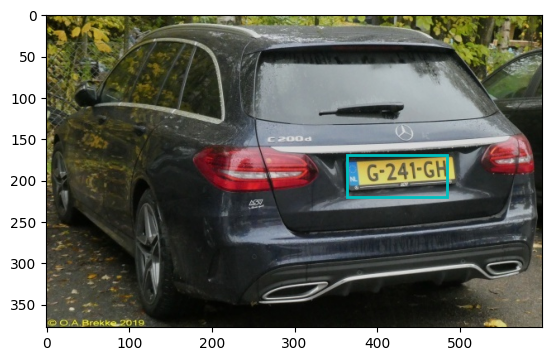

In [34]:
fig,ax = plt.subplots()
ax.imshow(img_arr)
rect = patches.Rectangle((xmin,ymin), xmax-xmin,ymax-ymin, linewidth=2, edgecolor='c', facecolor='none')

ax.add_patch(rect)
plt.savefig('test.jpeg')
plt.show()
